## Openfold Colab adaptation

This notebook is a modification of the OpenFold Colab notebook: https://colab.research.google.com/github/aqlaboratory/openfold/blob/main/notebooks/OpenFold.ipynb

In [2]:
import os

import torch

# A filthy hack to avoid slow Linear layer initialization
import openfold.model.primitives

def __default_linear_init__(self, *args, **kwargs):
    return torch.nn.Linear.__init__(
      self, 
      *args[:2], 
      **{k:v for k,v in kwargs.items() if k == "bias"}
    )

openfold.model.primitives.Linear.__init__ = __default_linear_init__

from openfold import config
from openfold.data import feature_pipeline
from openfold.data import data_pipeline
from openfold.model import model
from openfold.utils.import_weights import import_jax_weights_
from openfold.utils.tensor_utils import tensor_tree_map

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:
def _placeholder_template_feats(num_templates_, num_res_):
  return {
      'template_aatype': torch.zeros(num_templates_, num_res_, 22).long(),
      'template_all_atom_positions': torch.zeros(num_templates_, num_res_, 37, 3),
      'template_all_atom_mask': torch.zeros(num_templates_, num_res_, 37),
      'template_domain_names': torch.zeros(num_templates_),
      'template_sum_probs': torch.zeros(num_templates_, 1),
  }

In [6]:
import pickle

with open("../data_pickle/deletion_matrices.pickle", 'rb') as f:
    deletion_matrices = pickle.load(f)

with open("../data_pickle/msas.pickle", 'rb') as f:
    msas = pickle.load(f)

In [7]:
sequence = "MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW"

In [8]:
model_name = "model_1"

In [9]:
num_templates = 1 
num_res = len(sequence)

In [10]:
feature_dict = {}
feature_dict.update(data_pipeline.make_sequence_features(sequence, 'test', num_res))
feature_dict.update(data_pipeline.make_msa_features(msas, deletion_matrices=deletion_matrices))
feature_dict.update(_placeholder_template_feats(num_templates, num_res))

In [10]:
import pickle

filepath = "msa_arr.pickle"
output_dir = "./../data_pickle"
msa_output_path = os.path.join(output_dir, filepath)
with open(msa_output_path, 'wb') as f:
    pickle.dump(feature_dict['msa'], f, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
weight_set = "OpenFold"

In [12]:
cfg = config.model_config(model_name)
openfold_model = model.AlphaFold(cfg)
openfold_model = openfold_model.eval()

In [12]:
OPENFOLD_PARAMS_DIR = './openfold/resources/openfold_params'

In [14]:
if(weight_set == "OpenFold"):
  model_name_spl = model_name.split("_")

  if(model_name_spl[-1] == "ptm"):
    of_model_name = "finetuning_ptm_2.pt"
    
  else:
    of_model_name = f"finetuning_{model_name_spl[-1]}.pt"
    
  params_name = os.path.join(
    OPENFOLD_PARAMS_DIR,
    of_model_name
  )

  d = torch.load(params_name)
  openfold_model.load_state_dict(d)
else:
  raise ValueError(f"Invalid weight set: {weight_set}")

In [15]:
openfold_model = openfold_model.cuda()

In [16]:
pipeline = feature_pipeline.FeaturePipeline(cfg.data)
 
processed_feature_dict = pipeline.process_features(
  feature_dict, mode='predict'
)

/home/elio/Desktop/Thesis-MSc/openfold_model/openfold/data/feature_pipeline.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k: torch.tensor(v) for k, v in np_example.items() if k in features


		Recycling from configs
	CALLING MSA SAMPLING
2788110
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle
	CALLING MSA SAMPLING
2788110
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle
	CALLING MSA SAMPLING
2788110
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle
	CALLING MSA SAMPLING
2788110
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle


In [17]:
processed_feature_dict.keys()

dict_keys(['aatype', 'residue_index', 'seq_length', 'template_aatype', 'template_all_atom_positions', 'template_all_atom_mask', 'template_sum_probs', 'seq_mask', 'msa_mask', 'msa_row_mask', 'template_mask', 'template_pseudo_beta', 'template_pseudo_beta_mask', 'template_torsion_angles_sin_cos', 'template_alt_torsion_angles_sin_cos', 'template_torsion_angles_mask', 'atom14_atom_exists', 'residx_atom14_to_atom37', 'residx_atom37_to_atom14', 'atom37_atom_exists', 'extra_msa', 'extra_msa_mask', 'extra_msa_row_mask', 'bert_mask', 'true_msa', 'extra_has_deletion', 'extra_deletion_value', 'msa_feat', 'target_feat'])

In [18]:
processed_feature_dict['true_msa'].shape

torch.Size([512, 286, 4])

In [19]:
processed_feature_dict = tensor_tree_map(
    lambda t: t.cuda(), processed_feature_dict
)

In [20]:
processed_feature_dict['true_msa'].shape

torch.Size([512, 286, 1])

In [21]:
torch.cuda.empty_cache()

with torch.no_grad():
  prediction_result = openfold_model(processed_feature_dict)

In [22]:
prediction_result.keys()

dict_keys(['msa', 'pair', 'single', 'sm', 'final_atom_positions', 'final_atom_mask', 'final_affine_tensor', 'lddt_logits', 'plddt', 'distogram_logits', 'masked_msa_logits', 'experimentally_resolved_logits'])

In [23]:
prediction_result['msa']

tensor([[[  0.1191,  -9.6091,  10.6376,  ...,  16.7106,   5.8943,  -9.3006],
         [  1.4778,  -0.0605,   9.2424,  ...,  14.3378,   8.9431,  -8.1625],
         [ -3.0234, -12.3100, -13.6958,  ...,   9.7739,   6.6718,  -3.3194],
         ...,
         [  9.3769,  10.1555, -11.3802,  ...,  -7.1300,   7.1486,   7.5885],
         [ 10.6756, -20.5260, -15.4468,  ..., -12.4990,  -9.3852,   0.9390],
         [  3.1308,  -7.8135,  -6.2527,  ...,  -1.1047,  -1.4711,  -6.7019]],

        [[  5.4426,  -2.8225,  -4.8795,  ...,  -2.8427,  -6.8015,   3.0237],
         [  5.8724,  -3.6131,  -5.7323,  ...,  -1.6076,  -7.6941,  -0.2041],
         [  3.1117,  -1.3960,  -5.9726,  ...,  -2.0690,  -8.4099,   1.6113],
         ...,
         [  5.0194,  -4.6451,  -7.6387,  ...,  -1.3770,  -7.1926,   0.7363],
         [  5.7854,  -5.0206,  -7.0606,  ...,  -2.5019,  -6.1591,   0.6487],
         [  5.3092,  -4.4249,  -9.3564,  ...,  -2.2320,  -7.3628,   2.4500]],

        [[  3.5424,  -2.2098,  -5.3928,  ...

In [24]:
prediction_result['msa'].shape

torch.Size([512, 286, 256])

In [25]:
import pickle

filepath = "prediction_result.pickle"
output_dir = "./../data_pickle"
msa_output_path = os.path.join(output_dir, filepath)
with open(msa_output_path, 'wb') as f:
    pickle.dump(prediction_result, f, protocol=pickle.HIGHEST_PROTOCOL)

### 10 high vs 10 lows mutations

In [13]:
def full_pipeline(sequence, msas, deletion_matrices, filename):

    feature_dict = {}
    feature_dict.update(data_pipeline.make_sequence_features(sequence, 'test', num_res))
    feature_dict.update(data_pipeline.make_msa_features(msas, deletion_matrices=deletion_matrices))
    feature_dict.update(_placeholder_template_feats(num_templates, num_res))

    cfg = config.model_config(model_name)
    openfold_model = model.AlphaFold(cfg)
    openfold_model = openfold_model.eval()

    if(weight_set == "OpenFold"):
        model_name_spl = model_name.split("_")

        if(model_name_spl[-1] == "ptm"):
            of_model_name = "finetuning_ptm_2.pt"
            
        else:
            of_model_name = f"finetuning_{model_name_spl[-1]}.pt"
            
        params_name = os.path.join(
            OPENFOLD_PARAMS_DIR,
            of_model_name
        )

        d = torch.load(params_name)
        openfold_model.load_state_dict(d)
    else:
        raise ValueError(f"Invalid weight set: {weight_set}")

    openfold_model = openfold_model.cuda()

    pipeline = feature_pipeline.FeaturePipeline(cfg.data)
 
    processed_feature_dict = pipeline.process_features(
        feature_dict, mode='predict'
    )

    processed_feature_dict = tensor_tree_map(
        lambda t: t.cuda(), processed_feature_dict
    )

    torch.cuda.empty_cache()

    with torch.no_grad():
        prediction_result = openfold_model(processed_feature_dict)

    filename = filename + ".pickle"
    output_dir = "./../data_pickle/low_and_high_representation"
    output_path = os.path.join(output_dir, filename)
    with open(output_path, 'wb') as f:
        pickle.dump(prediction_result, f, protocol=pickle.HIGHEST_PROTOCOL)

In [14]:
import pickle5 as pickle

In [15]:
with open("../data_pickle/sequences_openfold_dict.pickle", 'rb') as f:
    sequences_openfold_dict = pickle.load(f)

In [16]:
sequences_openfold_dict.keys()

dict_keys(['low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10', 'high_1', 'high_2', 'high_3', 'high_4', 'high_5', 'high_6', 'high_7', 'high_8', 'high_9', 'high_10'])

In [17]:
'''
TODO: 
1)Run OpenFold the extract the MSA representation

2)Then do correlation of the first row of the representations

3)Then, for each first row of the MSA representation,
compute the delta elbo (on the model trained with the MSA representation of the original sequence),
correlate the delta elbo between the two groups of mutations

'''


for mutation_key in sequences_openfold_dict.keys():

    print(mutation_key)

    if mutation_key in [x.split('.')[0] for x in os.listdir("../data_pickle/low_and_high_representation/")]:
        print("\tFile already processed")
        continue

    try:

        sequence = sequences_openfold_dict[mutation_key]
        
        msas_filename = mutation_key + "_msas.pickle"

        with open("../data_pickle/low_and_high_msa/" + msas_filename, 'rb') as f:
            msas = pickle.load(f)


        deletion_matrices_filename = mutation_key + "_deletion_matrices.pickle"

        with open("../data_pickle/low_and_high_msa/" + deletion_matrices_filename, 'rb') as f:
            deletion_matrices = pickle.load(f)

        
        full_pipeline(sequence, msas, deletion_matrices, filename=mutation_key)

    except FileNotFoundError:
        print("\tNo file")

low_1


/home/elio/Desktop/Thesis-MSc/openfold_model/openfold/data/feature_pipeline.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k: torch.tensor(v) for k, v in np_example.items() if k in features


		Recycling from configs
	CALLING MSA SAMPLING
seed: 108
0
2744834
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle
	CALLING MSA SAMPLING
seed: 651
0
2821065
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle
	CALLING MSA SAMPLING
seed: 545
0
2736497
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle
	CALLING MSA SAMPLING
seed: 621
0
2726898
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle
low_2
		Recycling from configs
	CALLING MSA SAMPLING
seed: 588
0
2642247
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle
	CALLING MSA SAMPLING
seed: 521
0
2632740
Dumping pickle at ./../data_pickle/sel_seq.pickle
Dumping pickle at ./../data_pickle/not_sel_seq.pickle
	CALLING MSA SAMPLING
seed: 675
0
2808027
Dumping pickle at ./../dat

### Correlation between MSA representation (first row only)

In [18]:
folder_output = './../data_pickle/low_and_high_representation'

d = dict()

for output in os.listdir(folder_output):

    output_path = os.path.join(folder_output, output)

    with open(output_path, 'rb') as f:
        output_representation = pickle.load(f)
    
    output_name = output.split(".")[0]

    d[output_name] = output_representation['msa'][0].cpu().numpy()

In [19]:
d['low_1'].shape

(286, 256)

In [20]:
d.keys()

dict_keys(['low_3', 'low_4', 'high_3', 'low_2', 'high_2', 'high_5', 'high_1', 'low_1', 'high_4', 'low_5'])

In [21]:
from scipy.stats.stats import pearsonr 
import numpy as np

In [22]:
ordered_keys = ['low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'high_1', 'high_2', 'high_3', 'high_4', 'high_5']

In [23]:
corr_matrix = np.zeros((len(ordered_keys), len(ordered_keys)))
corr_matrix.shape

(10, 10)

In [24]:
for i, key_i in enumerate(ordered_keys):

    representation_i = d[key_i]

    for j, key_j in enumerate(ordered_keys):

        representation_j = d[key_j]

        list_corr = []

        for channel in range(256):
            list_corr.append(pearsonr(representation_i[:, channel], representation_j[:, channel])[0])
            
        corr = np.array(list_corr).mean()
        corr_matrix[i, j] = corr

In [25]:
corr_matrix

array([[1.        , 0.98584834, 0.98575235, 0.98198925, 0.98075869,
        0.98476074, 0.98251592, 0.98372581, 0.98475337, 0.98532739],
       [0.98584834, 1.        , 0.98887337, 0.98659314, 0.98885967,
        0.98800684, 0.98837381, 0.98756342, 0.98739574, 0.99019777],
       [0.98575235, 0.98887337, 1.        , 0.98994107, 0.98849093,
        0.98658999, 0.98648461, 0.98506605, 0.99021396, 0.98812129],
       [0.98198925, 0.98659314, 0.98994107, 1.        , 0.98622131,
        0.9851351 , 0.98448743, 0.9821114 , 0.98938194, 0.98538096],
       [0.98075869, 0.98885967, 0.98849093, 0.98622131, 1.        ,
        0.98198308, 0.98524455, 0.98248855, 0.98582942, 0.98536993],
       [0.98476074, 0.98800684, 0.98658999, 0.9851351 , 0.98198308,
        1.        , 0.98298573, 0.98477118, 0.98641474, 0.99039229],
       [0.98251592, 0.98837381, 0.98648461, 0.98448743, 0.98524455,
        0.98298573, 1.        , 0.98238478, 0.98435959, 0.98614479],
       [0.98372581, 0.98756342, 0.9850660

In [26]:
#!pip install seaborn

In [27]:
import seaborn as sns

<AxesSubplot:>

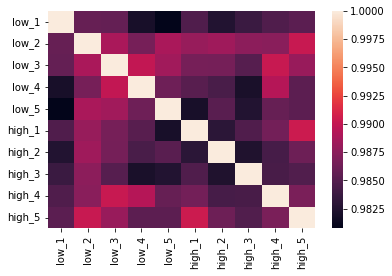

In [28]:
sns.heatmap(corr_matrix, xticklabels=ordered_keys, yticklabels=ordered_keys)

In [30]:
d_mean_by_category = dict()

In [31]:
sum_high = np.zeros((286, 256))
sum_low = np.zeros((286, 256))

In [32]:
for key in ordered_keys:

    if "high" in key:
        sum_high += d[key]
    else:
        sum_low += d[key]

d_mean_by_category['high'] = sum_high/5.0
d_mean_by_category['low'] = sum_low/2.0

In [33]:
corr_matrix_by_category = np.zeros((2, 2))
corr_matrix_by_category.shape

(2, 2)

In [34]:
categories = ['high', 'low']

In [35]:
for i, key_i in enumerate(categories):

    representation_i = d_mean_by_category[key_i]

    for j, key_j in enumerate(categories):

        representation_j = d_mean_by_category[key_j]

        list_corr = []

        for channel in range(256):
            list_corr.append(pearsonr(representation_i[:, channel], representation_j[:, channel])[0])
            
        corr = np.array(list_corr).mean()
        corr_matrix_by_category[i, j] = corr

In [36]:
corr_matrix_by_category

array([[1.        , 0.99715782],
       [0.99715782, 1.        ]])